<a href="https://colab.research.google.com/github/MalindaBotheju/Pixel-Perfect-Segmentation-UNet/blob/main/UNet_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Loading Oxford-IIIT Pet Dataset (Standard Segmentation Benchmark)...
   Data Ready: 3680 training images.

Starting Training (U-Net)...
Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 53s 623ms/step - accuracy: 0.5389 - loss: 1.1803 - val_accuracy: 0.5709 - val_loss: 0.8904
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 415ms/step - accuracy: 0.5953 - loss: 0.8506 - val_accuracy: 0.7012 - val_loss: 0.7240
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 410ms/step - accuracy: 0.7143 - loss: 0.6898 - val_accuracy: 0.6783 - val_loss: 0.7397
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 422ms/step - accuracy: 0.7170 - loss: 0.6619 - val_accuracy: 0.7356 - val_loss: 0.6248
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 415ms/step - accuracy: 0.7446 - loss: 0.6061 - val_accuracy: 0.7469 - val_loss: 0.6060
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 426ms/step - accuracy: 0.7679 - loss: 0.5568 - val_accuracy: 0.7898 - val_loss: 0.5156
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 433ms/step - accuracy: 0.7959 - loss: 0.4971 

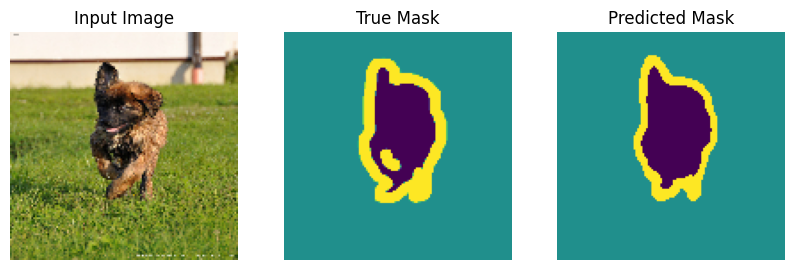

Project Complete.


In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# --- 1. SETUP & CONFIG ---
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

IMG_SIZE = 128
BATCH_SIZE = 64
BUFFER_SIZE = 1000

print("1. Loading Oxford-IIIT Pet Dataset (Standard Segmentation Benchmark)...")
# FIX: Removed the specific version number so it grabs the latest (4.0.0)
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

# --- 2. DATA PIPELINE (The "Engineer" Part) ---
def normalize(input_image, input_mask):
    # Resize to standard size
    input_image = tf.image.resize(input_image, (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(input_mask, (IMG_SIZE, IMG_SIZE))

    # Normalize image to [0, 1]
    input_image = tf.cast(input_image, tf.float32) / 255.0

    # The dataset mask pixels are 1, 2, 3. We shift them to 0, 1, 2.
    # 0 = Pet, 1 = Background, 2 = Border
    input_mask -= 1
    return input_image, input_mask

# Apply pipeline to Train and Test sets
train = dataset['train'].map(lambda x: (x['image'], x['segmentation_mask']), num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(lambda x: (x['image'], x['segmentation_mask']), num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train.map(normalize).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test.map(normalize).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"   Data Ready: {info.splits['train'].num_examples} training images.")

# --- 3. BUILD THE U-NET MODEL ---
def double_conv_block(x, n_filters):
    x = tf.keras.layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = tf.keras.layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = tf.keras.layers.concatenate([x, conv_features])
    x = double_conv_block(x, n_filters)
    return x

def build_unet():
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # ENCODER
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # BOTTLENECK
    bottleneck = double_conv_block(p4, 1024)

    # DECODER
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # OUTPUT
    outputs = tf.keras.layers.Conv2D(3, 1, padding="same", activation="softmax", dtype='float32')(u9)

    return tf.keras.Model(inputs, outputs, name="U-Net")

model = build_unet()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# --- 4. TRAIN ---
print("\nStarting Training (U-Net)...")
history = model.fit(train_ds, epochs=15, validation_data=test_ds)

# --- 5. VISUALIZE RESULTS ---
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i > 0:
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        else:
            plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

# Show result
for image, mask in test_ds.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    print("\nVisualizing Prediction:")
    display([image[0], mask[0], pred_mask[0]])

print("Project Complete.")